In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pyarrow.parquet as pq

In [2]:
X = pd.read_parquet("train_fe.parquet")
#X_test = pd.read_parquet("test.parquet")

In [26]:
X.iloc[[31608,32320,26513,63303]] #Des valeurs extrêmes qu'on supprime car elles perturberont le modèle

,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,pickup_day,journey_time,pickup_period_encoded
31610,1,1.0,1.0,0,1,12.8,5.0,0.5,0.0,1.0,2.5,0.00,40.768615,-73.965635,40.756688,-73.972356,19,15.0,1
32323,2,1.0,2.0,0,1,70.0,5.0,0.5,0.0,1.0,2.5,1.75,40.646985,-73.786530,40.717773,-74.007880,5,48.0,2
26514,1,1.0,1.0,0,1,10.7,2.5,0.5,0.0,1.0,2.5,0.00,40.775932,-73.946510,40.749914,-73.970443,2,7.0,0
63307,1,1.0,1.0,0,1,8.6,5.0,0.5,0.0,1.0,2.5,0.00,40.748427,-73.999918,40.735035,-74.008984,11,8.0,1


In [4]:
X.drop([31608,32320,26513,63303],axis=0,inplace=True)
y = X["tip_amount"]
X.drop(columns=["tip_amount"],inplace=True)

In [5]:

X.info()

#Pas de NAs

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               99996 non-null  int32  
 1   passenger_count        99996 non-null  float64
 2   trip_distance          99996 non-null  float64
 3   RatecodeID             99996 non-null  float64
 4   store_and_fwd_flag     99996 non-null  int32  
 5   payment_type           99996 non-null  int64  
 6   fare_amount            99996 non-null  float64
 7   extra                  99996 non-null  float64
 8   mta_tax                99996 non-null  float64
 9   tolls_amount           99996 non-null  float64
 10  improvement_surcharge  99996 non-null  float64
 11  congestion_surcharge   99996 non-null  float64
 12  Airport_fee            99996 non-null  float64
 13  PU_location_lat        99996 non-null  float64
 14  PU_location_lon        99996 non-null  float64
 15  DO_loca

In [6]:
#Suite à l'insight 1 et 2, on décide de supprimer tels features 

X.drop(columns=['pickup_hour'],inplace=True)
X.drop(columns=['dropoff_hour','dropoff_day'],inplace=True) #tropcorrélés à pickup_day et pickup_hour
X.drop(columns=['trip_distance'],inplace= True)


In [7]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import r2_score


In [8]:

X_train,X_test,y_train,y_test= train_test_split(X,y,train_size=0.8, random_state=42)

In [9]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb




xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=10, n_estimators=200)

params_random_xgb = {
    'learning_rate': [0.1]  # This is a single value, but RandomizedSearchCV will still work
}



randomized_xgb = RandomizedSearchCV(estimator=xgb_model,param_distributions=params_random_xgb,
                                    scoring="r2", cv=4,n_jobs=-1)
randomized_xgb.fit(X_train, y_train)


best_xgb_model = randomized_xgb.best_estimator_





C:\Users\rober\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [10]:
best_xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

In [11]:

y_pred = best_xgb_model.predict(X_test)

In [12]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print("R² :", r2)


R² : 0.7404306590825844


In [13]:



#en supprimant les outliers
#0.7378 en supprimant  dropoffs
#0.7391 sans le trip distance + dropoffs
#0.7404 sans le pickup_hour, le trip distance + dropoffs

In [14]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb



# Instancier un modèle XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',random_state=10)

# Random Search Parameters
params_random_xgb = {
    'learning_rate': np.arange(0.01, 1.01, 0.01), #De mémoire 0,13 et Grid_search avec les autres
    'n_estimators': [100,200],#pour le moins de 60 c'etait 100,200
    'max_depth': range(2, 12),
    'subsample': np.arange(0.02, 1.02, 0.02)
}



randomized_xgb = RandomizedSearchCV(param_distributions=params_random_xgb, estimator=xgb_model,
                                    scoring="r2", n_iter=60, cv=4,n_jobs=-1)


randomized_xgb.fit(X_train, y_train)


# Entraîner le modèle avec les meilleurs hyperparamètres
best_xgb_model = randomized_xgb.best_estimator_



In [15]:
best_xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.17, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

In [16]:
# Faire des prédictions sur le jeu de validation
y_pred = best_xgb_model.predict(X_test)

In [17]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print("R² :", r2)


R² : 0.748560028338643


In [18]:
#Pour la regression
import shap

explainer = shap.Explainer(best_xgb_model)


#


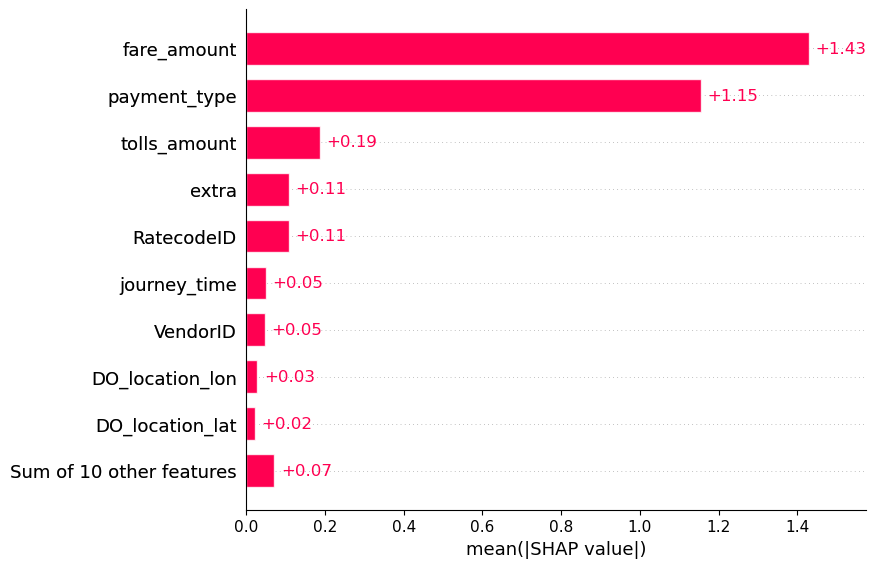

In [19]:
#
shap_values = explainer(X_test)


shap.plots.bar(shap_values)




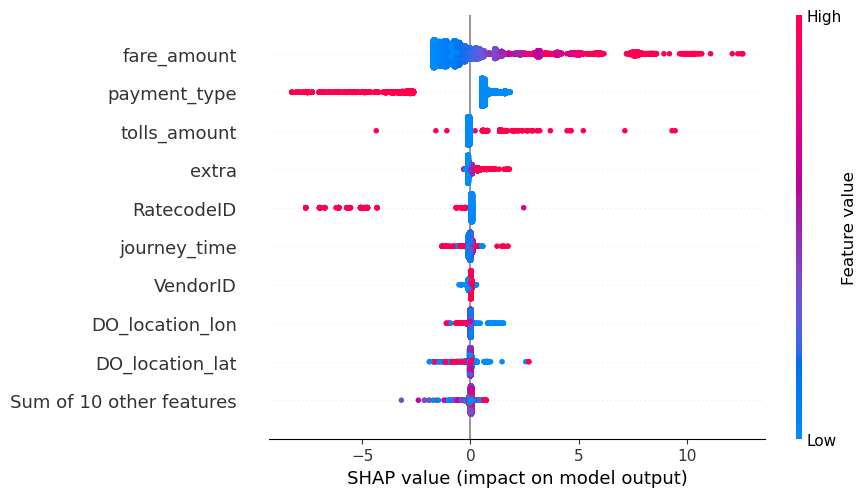

In [20]:
shap.plots.beeswarm(shap_values)

# Comme attendu le prix du trajet influe positiviment sur des valeurs de pourboire elevés. Par contre, un peu plus inattendu
#de payemnt-type élévés (Group ride, Negotiated Fare) influe fortement négativement sur le montant du pourboire 
#En y réfléchissant, ce n'est pas si surprenant. Ceux qui payent en carte ou en cash ont tendance à donner plus en pourboire



In [21]:
#Faire un XG Boost de feature_importance pour contraster 

In [22]:
X.to_parquet("train_fe2.parquet") #fe pour feature engineering

In [24]:

y_df = pd.DataFrame(y)

y_df.to_parquet("train_tip_amount_fe.parquet")

##### Regression logistique